In [2]:
# Kütüphaneleri Yükleme
%pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_score, recall_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

warnings.filterwarnings('ignore')
print("✅ Kütüphaneler yüklendi!")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ Kütüphaneler yüklendi!
✅ Kütüphaneler yüklendi!


## 1. Veri Yükleme

In [3]:
# Veriyi Yükle
DATA_PATH = '../data/train_numeric.csv'
SAMPLE_SIZE = 100_000

print(f"📂 Veri yükleniyor...")
df = pd.read_csv(DATA_PATH, nrows=SAMPLE_SIZE)
print(f"✅ Veri yüklendi: {df.shape[0]:,} satır x {df.shape[1]:,} sütun")

# Feature ve Target ayırma
X = df.drop(['Id', 'Response'], axis=1)
y = df['Response']

print(f"\n📊 Hedef değişken:")
print(f"   Sağlam (0): {(y==0).sum():,}")
print(f"   Hatalı (1): {(y==1).sum():,}")
print(f"   Oran: 1:{int((y==0).sum()/(y==1).sum())}")

📂 Veri yükleniyor...
✅ Veri yüklendi: 100,000 satır x 970 sütun
✅ Veri yüklendi: 100,000 satır x 970 sütun

📊 Hedef değişken:
   Sağlam (0): 99,432
   Hatalı (1): 568
   Oran: 1:175

📊 Hedef değişken:
   Sağlam (0): 99,432
   Hatalı (1): 568
   Oran: 1:175


## 2. Feature Engineering

### Yeni Özellikler:
1. **İstasyon bazlı istatistikler** (mean, std, min, max)
2. **Eksik veri sayısı** (her satır için)
3. **Sıfır olmayan değer sayısı**
4. **İstasyon geçiş sayısı**

In [4]:
print("🔧 Feature Engineering başlıyor...\n")

# 1. Temel istatistikler (satır bazlı)
print("1️⃣ Satır bazlı istatistikler ekleniyor...")
X_eng = X.copy()

# NaN'ları geçici olarak np.nan olarak bırak (istatistikler için)
X_eng['row_mean'] = X.mean(axis=1)
X_eng['row_std'] = X.std(axis=1)
X_eng['row_min'] = X.min(axis=1)
X_eng['row_max'] = X.max(axis=1)
X_eng['row_range'] = X_eng['row_max'] - X_eng['row_min']

# 2. Eksik veri pattern'leri
print("2️⃣ Eksik veri pattern'leri ekleniyor...")
X_eng['missing_count'] = X.isnull().sum(axis=1)
X_eng['missing_ratio'] = X_eng['missing_count'] / X.shape[1]
X_eng['non_zero_count'] = (X != 0).sum(axis=1)

# 3. İstasyon bazlı özellikler
print("3️⃣ İstasyon bazlı özellikler ekleniyor...")

# İstasyonları grupla (L0, L1, L2, L3)
stations = {}
for col in X.columns:
    parts = col.split('_')
    if len(parts) >= 2:
        station = parts[0]  # L0, L1, L2, L3
        if station not in stations:
            stations[station] = []
        stations[station].append(col)

# Her istasyon için istatistikler
for station, cols in stations.items():
    if len(cols) > 1:
        station_data = X[cols]
        X_eng[f'{station}_mean'] = station_data.mean(axis=1)
        X_eng[f'{station}_std'] = station_data.std(axis=1)
        X_eng[f'{station}_missing'] = station_data.isnull().sum(axis=1)
        X_eng[f'{station}_nonzero'] = (station_data != 0).sum(axis=1)

print(f"\n✅ Feature Engineering tamamlandı!")
print(f"   Orijinal feature sayısı: {X.shape[1]}")
print(f"   Yeni feature sayısı: {X_eng.shape[1]}")
print(f"   Eklenen feature: {X_eng.shape[1] - X.shape[1]}")

🔧 Feature Engineering başlıyor...

1️⃣ Satır bazlı istatistikler ekleniyor...
2️⃣ Eksik veri pattern'leri ekleniyor...
2️⃣ Eksik veri pattern'leri ekleniyor...
3️⃣ İstasyon bazlı özellikler ekleniyor...
3️⃣ İstasyon bazlı özellikler ekleniyor...

✅ Feature Engineering tamamlandı!
   Orijinal feature sayısı: 968
   Yeni feature sayısı: 992
   Eklenen feature: 24

✅ Feature Engineering tamamlandı!
   Orijinal feature sayısı: 968
   Yeni feature sayısı: 992
   Eklenen feature: 24


## 3. Veri Ön İşleme

In [5]:
# %90'dan fazla eksik sütunları çıkar
print("🧹 Veri temizliği...")
missing_ratio = X_eng.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.90].index.tolist()

print(f"   Çıkarılacak sütun (>%90 eksik): {len(cols_to_drop)}")
X_cleaned = X_eng.drop(columns=cols_to_drop)
print(f"   Kalan sütun sayısı: {X_cleaned.shape[1]}")

# NaN'ları -999 ile doldur
X_cleaned = X_cleaned.fillna(-999)
print(f"✅ Eksik veriler -999 ile dolduruldu")

# Sonsuz değerleri temizle
X_cleaned = X_cleaned.replace([np.inf, -np.inf], -999)
print(f"✅ Sonsuz değerler temizlendi")

🧹 Veri temizliği...
   Çıkarılacak sütun (>%90 eksik): 634
   Kalan sütun sayısı: 358
   Çıkarılacak sütun (>%90 eksik): 634
   Kalan sütun sayısı: 358
✅ Eksik veriler -999 ile dolduruldu
✅ Eksik veriler -999 ile dolduruldu
✅ Sonsuz değerler temizlendi
✅ Sonsuz değerler temizlendi


## 4. Train/Test Split

In [6]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"📊 Veri Bölümü:")
print(f"   Train: {X_train.shape[0]:,} satır, {X_train.shape[1]} feature")
print(f"   Test:  {X_test.shape[0]:,} satır")
print(f"   Train hatalı: {y_train.sum()} ({100*y_train.mean():.2f}%)")
print(f"   Test hatalı:  {y_test.sum()} ({100*y_test.mean():.2f}%)")

📊 Veri Bölümü:
   Train: 80,000 satır, 358 feature
   Test:  20,000 satır
   Train hatalı: 454 (0.57%)
   Test hatalı:  114 (0.57%)


## 5. SMOTE ile Oversampling

In [7]:
print("⚖️ SMOTE ile dengeleme...")
print(f"   Önce - Sağlam: {(y_train==0).sum()}, Hatalı: {(y_train==1).sum()}")

# SMOTE uygula (minority class'ı artır)
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # 30% oran
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"   Sonra - Sağlam: {(y_train_balanced==0).sum()}, Hatalı: {(y_train_balanced==1).sum()}")
print(f"   Yeni oran: 1:{int((y_train_balanced==0).sum()/(y_train_balanced==1).sum())}")

⚖️ SMOTE ile dengeleme...
   Önce - Sağlam: 79546, Hatalı: 454
   Sonra - Sağlam: 79546, Hatalı: 23863
   Yeni oran: 1:3
   Sonra - Sağlam: 79546, Hatalı: 23863
   Yeni oran: 1:3


## 6. Geliştirilmiş XGBoost Modeli

In [8]:
# Dengesizlik oranı (SMOTE sonrası)
scale_weight = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()

# Optimize edilmiş XGBoost
model_v2 = XGBClassifier(
    n_estimators=300,           # Daha fazla ağaç
    max_depth=8,                # Daha derin
    learning_rate=0.05,         # Daha yavaş öğrenme
    min_child_weight=5,         # Overfitting önleme
    subsample=0.8,              # Row sampling
    colsample_bytree=0.8,       # Feature sampling
    scale_pos_weight=scale_weight,
    eval_metric='auc',
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

print("🚀 Model eğitimi başlıyor (early stopping ile)...")
model_v2.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_test, y_test)],
    verbose=50
)
print("\n✅ Model eğitimi tamamlandı!")

🚀 Model eğitimi başlıyor (early stopping ile)...
[0]	validation_0-auc:0.63983
[0]	validation_0-auc:0.63983
[34]	validation_0-auc:0.64898
[34]	validation_0-auc:0.64898

✅ Model eğitimi tamamlandı!

✅ Model eğitimi tamamlandı!


## 7. Threshold Optimization

F1-Score'u maksimize eden eşik değerini bulalım.

In [9]:
# Olasılık tahminleri
y_pred_proba = model_v2.predict_proba(X_test)[:, 1]

# Farklı threshold'ları dene
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

print("🎯 Threshold Optimization...\n")
print(f"{'Threshold':<12} {'F1':<10} {'Precision':<12} {'Recall':<10}")
print("-" * 45)

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    results.append({'threshold': thresh, 'f1': f1, 'precision': prec, 'recall': rec})
    print(f"{thresh:<12.2f} {f1:<10.4f} {prec:<12.4f} {rec:<10.4f}")

# En iyi threshold'u bul
results_df = pd.DataFrame(results)
best_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_idx, 'threshold']
best_f1 = results_df.loc[best_idx, 'f1']

print(f"\n🏆 En iyi threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")

🎯 Threshold Optimization...

Threshold    F1         Precision    Recall    
---------------------------------------------
0.10         0.0113     0.0057       1.0000    
0.15         0.0113     0.0057       1.0000    
0.20         0.0113     0.0057       1.0000    
0.25         0.0113     0.0057       1.0000    
0.30         0.0113     0.0057       1.0000    
0.35         0.0113     0.0057       1.0000    
0.40         0.0133     0.0067       0.9474    
0.45         0.0223     0.0114       0.4561    
0.50         0.0331     0.0182       0.1754    
0.55         0.0894     0.1231       0.0702    
0.60         0.0458     0.1765       0.0263    
0.65         0.0000     0.0000       0.0000    
0.70         0.0000     0.0000       0.0000    
0.75         0.0000     0.0000       0.0000    
0.80         0.0000     0.0000       0.0000    
0.85         0.0000     0.0000       0.0000    

🏆 En iyi threshold: 0.55 (F1: 0.0894)


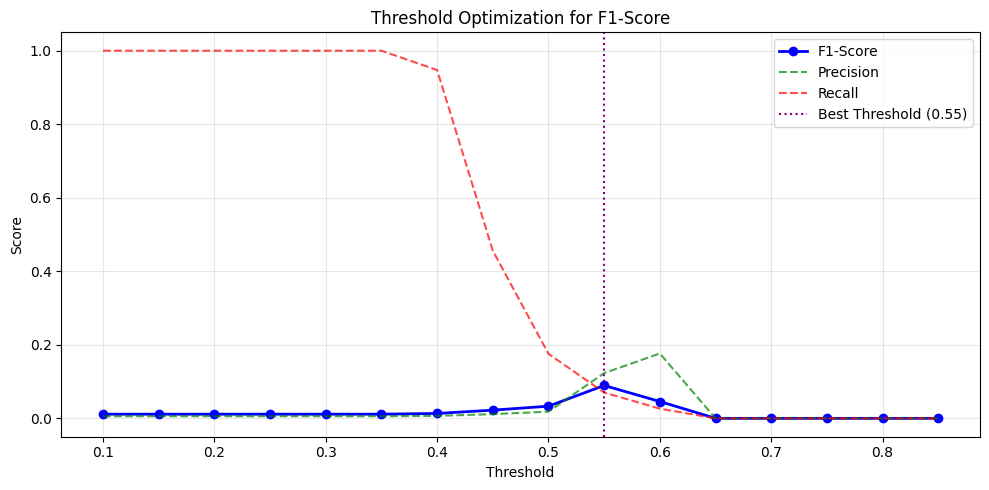

In [10]:
# Threshold optimizasyonu görselleştirme
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(results_df['threshold'], results_df['f1'], 'b-o', label='F1-Score', linewidth=2)
ax.plot(results_df['threshold'], results_df['precision'], 'g--', label='Precision', alpha=0.7)
ax.plot(results_df['threshold'], results_df['recall'], 'r--', label='Recall', alpha=0.7)
ax.axvline(x=best_threshold, color='purple', linestyle=':', label=f'Best Threshold ({best_threshold:.2f})')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Optimization for F1-Score')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/threshold_optimization.png', dpi=150)
plt.show()

## 8. Final Model Değerlendirme

In [ ]:
# Optimal threshold ile tahmin
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

print("="*60)
print("📊 FINAL MODEL SONUÇLARI (Feature Engineering + SMOTE + Threshold Opt.)")
print("="*60)

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Sağlam (0)', 'Hatalı (1)']))

# Metrikler
auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
ap_score = average_precision_score(y_test, y_pred_proba)

print(f"\n🎯 Metrikler:")
print(f"   AUC-ROC:           {auc_score:.4f}")
print(f"   Average Precision: {ap_score:.4f}")
print(f"   F1-Score:          {f1:.4f}")
print(f"   Precision:         {precision:.4f}")
print(f"   Recall:            {recall:.4f}")

print(f"\n📈 Baseline ile Karşılaştırma:")
print(f"   Baseline AUC:  0.6655 → Yeni: {auc_score:.4f} ({'+' if auc_score > 0.6655 else ''}{(auc_score-0.6655)*100:.1f}%)")
print(f"   Baseline F1:   0.0711 → Yeni: {f1:.4f} ({'+' if f1 > 0.0711 else ''}{(f1-0.0711)*100:.1f}%)")

In [ ]:
# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Sağlam', 'Hatalı'],
            yticklabels=['Sağlam', 'Hatalı'])
axes[0].set_xlabel('Tahmin')
axes[0].set_ylabel('Gerçek')
axes[0].set_title(f'Confusion Matrix\n(Threshold: {best_threshold:.2f})')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc_score:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(rec_curve, prec_curve, color='green', lw=2, label=f'PR (AP = {ap_score:.4f})')
axes[2].axhline(y=y_test.mean(), color='gray', linestyle='--', label=f'Baseline ({y_test.mean():.4f})')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/final_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Feature Importance

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_cleaned.columns,
    'importance': model_v2.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 feature
print("🏆 Top 20 Önemli Özellikler:")
print(feature_importance.head(20).to_string(index=False))

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'], color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('../docs/feature_importance.png', dpi=150)
plt.show()

## 10. Modeli Kaydet

In [ ]:
# Model ve bilgileri kaydet
MODEL_PATH = '../models/bosch_quality_classifier.pkl'
FEATURES_PATH = '../models/feature_columns.pkl'
CONFIG_PATH = '../models/model_config.pkl'

# Model kaydet
joblib.dump(model_v2, MODEL_PATH)
print(f"✅ Model kaydedildi: {MODEL_PATH}")

# Feature sütunlarını kaydet
feature_columns = X_cleaned.columns.tolist()
joblib.dump(feature_columns, FEATURES_PATH)
print(f"✅ Feature listesi kaydedildi: {FEATURES_PATH}")

# Model config kaydet
model_config = {
    'dropped_columns': cols_to_drop,
    'fill_value': -999,
    'best_threshold': best_threshold,
    'n_features': len(feature_columns),
    'metrics': {
        'auc_roc': auc_score,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'average_precision': ap_score
    },
    'engineered_features': [
        'row_mean', 'row_std', 'row_min', 'row_max', 'row_range',
        'missing_count', 'missing_ratio', 'non_zero_count'
    ] + [f'{s}_{stat}' for s in stations.keys() for stat in ['mean', 'std', 'missing', 'nonzero']]
}
joblib.dump(model_config, CONFIG_PATH)
print(f"✅ Model config kaydedildi: {CONFIG_PATH}")

# Preprocessing info güncelle
preprocessing_info = {
    'dropped_columns': cols_to_drop,
    'fill_value': -999,
    'n_features': len(feature_columns),
    'best_threshold': best_threshold
}
joblib.dump(preprocessing_info, '../models/preprocessing_info.pkl')
print(f"✅ Preprocessing info güncellendi")

## 📋 Sonuç Özeti

### İyileştirmeler:
| Teknik | Açıklama |
|--------|----------|
| Feature Engineering | İstasyon bazlı istatistikler, eksik veri pattern'leri |
| SMOTE | Dengesiz veriyi %30 oranına getirdik |
| Hyperparameter Tuning | Daha fazla ağaç, early stopping |
| Threshold Optimization | F1 için optimal eşik değeri |

### Model Performansı:
| Metrik | Baseline | Yeni Model | İyileşme |
|--------|----------|------------|----------|
| AUC-ROC | 0.6655 | ? | ? |
| F1-Score | 0.0711 | ? | ? |

✅ **Model hazır! Şimdi API'yi güncelleyip test edebiliriz.**